# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [2]:
import h2o
import os
import numpy as np
import math
import shap
import pandas as pd

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch 

# init h2o
h2o.init(max_mem_size='12G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,10 mins 53 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,23 days
H2O cluster name:,H2O_from_python_ngill_vo2rw9
H2O cluster total nodes:,1
H2O cluster free memory:,10.27 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [3]:
train_path = os.sep.join(['..', 'data', 'output', 'hmda_train.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'hmda_test.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
train.head()

derived_loan_product_type,derived_ethnicity,derived_race,derived_sex,loan_purpose,loan_purpose_desc,reverse_mortgage,reverse_mortgage_desc,loan_amount,loan_to_value_ratio,high_priced,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,negative_amortization_desc,interest_only_payment,interest_only_payment_desc,balloon_payment,balloon_payment_desc,property_value,income,debt_to_income_ratio,applicant_credit_score_type,applicant_credit_score_type_desc,co_applicant_credit_score_type,co_applicant_credit_score_type_desc,applicant_age,co_applicant_age,applicant_age_above_62,co_applicant_age_above_62,cv_fold
Conventional:First Lien,Not Hispanic or Latino,White,Male,1,Home purchase,2,Not a reverse mortgage,75000,95,0,1068.75,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,75000,33,36,3,FICO Risk Score Classic 04,10,No co-applicant,25-34,9999,No,,3
Conventional:First Lien,Hispanic or Latino,White,Male,1,Home purchase,2,Not a reverse mortgage,545000,100,0,nan,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,545000,298,nan,1,Equifax Beacon 5.0,10,No co-applicant,35-44,9999,No,,0
Conventional:First Lien,Ethnicity Not Available,Race Not Available,Male,1,Home purchase,2,Not a reverse mortgage,345000,68.082,0,nan,1735,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,515000,78,43,3,FICO Risk Score Classic 04,10,No co-applicant,35-44,9999,No,,1
VA:First Lien,Not Hispanic or Latino,White,Male,1,Home purchase,2,Not a reverse mortgage,265000,100,0,2873.67,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,265000,181,nan,1,Equifax Beacon 5.0,10,No co-applicant,45-54,9999,No,,1
Conventional:First Lien,Not Hispanic or Latino,White,Male,1,Home purchase,2,Not a reverse mortgage,185000,95,0,nan,42.5,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,195000,194,nan,3,FICO Risk Score Classic 04,9,Not applicable,25-34,nan,No,No,3
Conventional:First Lien,Not Hispanic or Latino,White,Female,1,Home purchase,2,Not a reverse mortgage,105000,95,0,nan,399,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,115000,79,nan,1,Equifax Beacon 5.0,9,Not applicable,25-34,nan,No,No,3
Conventional:First Lien,Not Hispanic or Latino,White,Joint,1,Home purchase,2,Not a reverse mortgage,315000,60,0,nan,nan,180,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,515000,167,nan,1,Equifax Beacon 5.0,2,Experian Fair Isaac,55-64,nan,No,No,4
Conventional:First Lien,Ethnicity Not Available,Race Not Available,Joint,1,Home purchase,2,Not a reverse mortgage,325000,55.036,0,9047.5,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,595000,90,nan,9,Not applicable,1,Equifax Beacon 5.0,65-74,nan,Yes,Yes,0
Conventional:First Lien,Hispanic or Latino,White,Joint,1,Home purchase,2,Not a reverse mortgage,175000,79.817,0,6567.29,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,225000,61,nan,1,Equifax Beacon 5.0,1,Equifax Beacon 5.0,35-44,nan,No,No,2
Conventional:First Lien,Ethnicity Not Available,Race Not Available,Sex Not Available,1,Home purchase,2,Not a reverse mortgage,185000,95,1,nan,1389.38,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,195000,61,49,2,Experian Fair Isaac,9,Not applicable,65-74,nan,Yes,Yes,0


In [5]:
train.summary()

,derived_loan_product_type,derived_ethnicity,derived_race,derived_sex,loan_purpose,loan_purpose_desc,reverse_mortgage,reverse_mortgage_desc,loan_amount,loan_to_value_ratio,high_priced,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,negative_amortization_desc,interest_only_payment,interest_only_payment_desc,balloon_payment,balloon_payment_desc,property_value,income,debt_to_income_ratio,applicant_credit_score_type,applicant_credit_score_type_desc,co_applicant_credit_score_type,co_applicant_credit_score_type_desc,applicant_age,co_applicant_age,applicant_age_above_62,co_applicant_age_above_62,cv_fold
type,enum,enum,enum,enum,int,enum,int,enum,int,real,int,real,real,int,int,int,int,enum,int,enum,int,enum,int,int,int,int,enum,int,enum,enum,int,enum,enum,int
mins,,,,,1.0,,1.0,,5000.0,0.07,0.0,0.01,0.01,1.0,0.0,1.0,1.0,,1.0,,1.0,,5000.0,-4.0,36.0,1.0,,1.0,,,8888.0,,,0.0
mean,,,,,1.0,,2.2845347222222214,,275712.91666666674,93.63980445093523,0.1093125,1780.7813216567938,952.6263970252761,348.3484510274331,16.09090909090909,93.9097736177623,2.4235277777777764,,2.407701388888889,,2.416208333333334,,366956.4594672014,129.04048188377845,42.4431987050207,3.2556041666666666,,8.367777777777778,,,9996.58974651747,,,2.0004166666666676
maxs,,,,,1.0,,1111.0,,14005000.0,643500.0,1.0,110262.0,99999.99,729.0,54.0,425.0,1111.0,,1111.0,,1111.0,,775005000.0,163000.0,49.0,1111.0,,1111.0,,,9999.0,,,4.0
sigma,,,,,0.0,,17.774496924348146,,233379.4103005898,1777.5534748671541,0.31203197509600816,2308.3904654772614,1767.5166321369227,46.84578614785412,18.069874824567783,58.02179976615468,21.66956734718421,,21.67023606148193,,21.669878055815712,,3043850.7368578054,1461.2876571502493,3.9599927734968032,18.622289468519252,,18.650985293481092,,,51.691548599473755,,,1.4153620911121243
zeros,,,,,0,,0,,0,0,128259,0,0,0,47,0,0,,0,,0,,0,738,0,0,,0,,,0,,,28942
missing,0,0,0,0,0,0,0,0,0,3833,0,101122,89205,195,143912,134812,0,0,0,0,0,0,869,1393,68632,0,0,0,0,0,65178,62,78822,0
0,Conventional:First Lien,Not Hispanic or Latino,White,Male,1.0,Home purchase,2.0,Not a reverse mortgage,75000.0,95.0,0.0,1068.75,nan,360.0,nan,nan,2.0,No negative amortization,2.0,No interest-only payments,2.0,No balloon payment,75000.0,33.0,36.0,3.0,FICO Risk Score Classic 04,10.0,No co-applicant,25-34,9999.0,No,,3.0
1,Conventional:First Lien,Hispanic or Latino,White,Male,1.0,Home purchase,2.0,Not a reverse mortgage,545000.0,100.0,0.0,nan,nan,360.0,nan,nan,2.0,No negative amortization,2.0,No interest-only payments,2.0,No balloon payment,545000.0,298.0,nan,1.0,Equifax Beacon 5.0,10.0,No co-applicant,35-44,9999.0,No,,0.0
2,Conventional:First Lien,Ethnicity Not Available,Race Not Available,Male,1.0,Home purchase,2.0,Not a reverse mortgage,345000.0,68.082,0.0,nan,1735.0,360.0,nan,nan,2.0,No negative amortization,2.0,No interest-only payments,2.0,No balloon payment,515000.0,78.0,43.0,3.0,FICO Risk Score Classic 04,10.0,No co-applicant,35-44,9999.0,No,,1.0


In [6]:
test.head()

derived_loan_product_type,derived_ethnicity,derived_race,derived_sex,loan_purpose,loan_purpose_desc,reverse_mortgage,reverse_mortgage_desc,loan_amount,loan_to_value_ratio,high_priced,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,negative_amortization_desc,interest_only_payment,interest_only_payment_desc,balloon_payment,balloon_payment_desc,property_value,income,debt_to_income_ratio,applicant_credit_score_type,applicant_credit_score_type_desc,co_applicant_credit_score_type,co_applicant_credit_score_type_desc,applicant_age,co_applicant_age,applicant_age_above_62,co_applicant_age_above_62
VA:First Lien,Not Hispanic or Latino,Black or African American,Sex Not Available,1,Home purchase,2,Not a reverse mortgage,235000,100,0,nan,537.38,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,235000,68,37,1,Equifax Beacon 5.0,10,No co-applicant,45-54,9999,No,
VA:First Lien,Ethnicity Not Available,Race Not Available,Male,1,Home purchase,2,Not a reverse mortgage,155000,100,0,nan,462.94,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,155000,45,38,1,Equifax Beacon 5.0,10,No co-applicant,25-34,9999,No,
Conventional:First Lien,Ethnicity Not Available,White,Male,1,Home purchase,2,Not a reverse mortgage,255000,80,0,nan,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,325000,78,46,2,Experian Fair Isaac,10,No co-applicant,45-54,9999,No,
Conventional:First Lien,Not Hispanic or Latino,White,Joint,1,Home purchase,2,Not a reverse mortgage,355000,95,0,nan,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,385000,179,nan,1,Equifax Beacon 5.0,9,Not applicable,45-54,nan,No,No
FHA:First Lien,Not Hispanic or Latino,White,Joint,1,Home purchase,2,Not a reverse mortgage,165000,96.5,0,1114.63,nan,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,175000,102,nan,3,FICO Risk Score Classic 04,9,Not applicable,35-44,nan,No,No
Conventional:First Lien,Not Hispanic or Latino,White,Joint,1,Home purchase,2,Not a reverse mortgage,125000,97,0,nan,750,240,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,135000,47,44,3,FICO Risk Score Classic 04,9,Not applicable,25-34,nan,No,No
Conventional:First Lien,Not Hispanic or Latino,White,Joint,1,Home purchase,2,Not a reverse mortgage,145000,85,0,nan,300,360,nan,60,2,No negative amortization,2,No interest-only payments,2,No balloon payment,185000,113,nan,8,Other credit scoring model,8,Other credit scoring model,25-34,nan,No,No
Conventional:First Lien,Not Hispanic or Latino,Asian,Female,1,Home purchase,2,Not a reverse mortgage,685000,75,0,nan,nan,360,nan,84,2,No negative amortization,2,No interest-only payments,2,No balloon payment,915000,220,nan,2,Experian Fair Isaac,10,No co-applicant,25-34,9999,No,
VA:First Lien,Not Hispanic or Latino,White,Male,1,Home purchase,2,Not a reverse mortgage,205000,100,0,nan,1057.04,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,205000,46,42,3,FICO Risk Score Classic 04,10,No co-applicant,35-44,9999,No,
Conventional:First Lien,Not Hispanic or Latino,White,Male,1,Home purchase,2,Not a reverse mortgage,65000,95,0,nan,350,360,nan,nan,2,No negative amortization,2,No interest-only payments,2,No balloon payment,nan,67,nan,9,Not applicable,10,No co-applicant,45-54,9999,No,


In [7]:
test.summary()

,derived_loan_product_type,derived_ethnicity,derived_race,derived_sex,loan_purpose,loan_purpose_desc,reverse_mortgage,reverse_mortgage_desc,loan_amount,loan_to_value_ratio,high_priced,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,negative_amortization_desc,interest_only_payment,interest_only_payment_desc,balloon_payment,balloon_payment_desc,property_value,income,debt_to_income_ratio,applicant_credit_score_type,applicant_credit_score_type_desc,co_applicant_credit_score_type,co_applicant_credit_score_type_desc,applicant_age,co_applicant_age,applicant_age_above_62,co_applicant_age_above_62
type,enum,enum,enum,enum,int,enum,int,enum,int,real,int,real,real,int,int,int,int,enum,int,enum,int,enum,int,int,int,int,enum,int,enum,enum,int,enum,enum
mins,,,,,1.0,,1.0,,5000.0,1.0,0.0,0.01,0.01,6.0,0.0,1.0,1.0,,1.0,,1.0,,5000.0,0.0,36.0,1.0,,1.0,,,8888.0,,
mean,,,,,1.0,,2.3386388888888887,,276516.6666666667,89.69511914493116,0.10875,1757.3937057039986,958.7801254896272,348.46688170847,21.75,93.46895640686922,2.3696388888888893,,2.3532777777777776,,2.3613333333333335,,350258.2907272372,129.19422483880012,42.46012464349845,3.359722222222223,,8.502444444444444,,,9996.926506935684,,
maxs,,,,,1.0,,1111.0,,9705000.0,101446.0,1.0,68400.0,55459.0,480.0,54.0,360.0,1111.0,,1111.0,,1111.0,,144005000.0,179000.0,49.0,1111.0,,1111.0,,,9999.0,,
sigma,,,,,0.0,,19.38280047007571,,232690.83775031558,542.0284475439462,0.31132961615062743,2295.349372497006,1774.6607391132238,46.70574574957731,18.45617606067434,58.69896906923912,20.244384715560336,,20.245080936505943,,20.244739800672498,,864710.201510732,1569.0416971291431,3.9418031374119744,21.97870854868645,,21.974950817384173,,,47.95276226904456,,
zeros,,,,,0,,0,,0,0,32085,0,0,0,9,0,0,,0,,0,,0,167,0,0,,0,,,0,,
missing,0,0,0,0,0,0,0,0,0,1001,0,25446,22214,38,35976,33729,0,0,0,0,0,0,207,330,17066,0,0,0,0,0,16175,15,19825
0,VA:First Lien,Not Hispanic or Latino,Black or African American,Sex Not Available,1.0,Home purchase,2.0,Not a reverse mortgage,235000.0,100.0,0.0,nan,537.38,360.0,nan,nan,2.0,No negative amortization,2.0,No interest-only payments,2.0,No balloon payment,235000.0,68.0,37.0,1.0,Equifax Beacon 5.0,10.0,No co-applicant,45-54,9999.0,No,
1,VA:First Lien,Ethnicity Not Available,Race Not Available,Male,1.0,Home purchase,2.0,Not a reverse mortgage,155000.0,100.0,0.0,nan,462.94,360.0,nan,nan,2.0,No negative amortization,2.0,No interest-only payments,2.0,No balloon payment,155000.0,45.0,38.0,1.0,Equifax Beacon 5.0,10.0,No co-applicant,25-34,9999.0,No,
2,Conventional:First Lien,Ethnicity Not Available,White,Male,1.0,Home purchase,2.0,Not a reverse mortgage,255000.0,80.0,0.0,nan,nan,360.0,nan,nan,2.0,No negative amortization,2.0,No interest-only payments,2.0,No balloon payment,325000.0,78.0,46.0,2.0,Experian Fair Isaac,10.0,No co-applicant,45-54,9999.0,No,


In [9]:
# Inputs and output
X = ['derived_loan_product_type', 
     'loan_purpose_desc',  
     'reverse_mortgage_desc', 
     'loan_amount', 
     'loan_to_value_ratio', 
     'discount_points', 
     'lender_credits', 
     'loan_term', 
     'prepayment_penalty_term', 
     'intro_rate_period',  
     'negative_amortization_desc',  
     'interest_only_payment_desc', 
     'balloon_payment_desc', 
     'property_value', 
     'income', 
     'debt_to_income_ratio', 
     'applicant_credit_score_type_desc', 
     'co_applicant_credit_score_type_desc']
fold_column = 'cv_fold'
Y = "high_priced"

In [14]:
# Convert outcome to categorical
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

In [15]:
# Create Pandas frame for correlation purposes
train_pd_for_corr = train.as_data_frame()

In [16]:
# Get correlation
numeric_corr = pd.DataFrame(train_pd_for_corr[X + [Y]].corr()[Y]).iloc[:-1]
numeric_corr

,high_priced
loan_amount,-0.122799
loan_to_value_ratio,0.001567
discount_points,-0.028771
lender_credits,0.004091
loan_term,-0.003213
prepayment_penalty_term,0.059624
intro_rate_period,-0.051503
property_value,-0.016780
income,-0.010434
debt_to_income_ratio,0.033009


In [17]:
# Apply monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train_pd_for_corr[X + [Y]].corr()[Y].values[:-1])])
mono_constraints = dict(zip(list(numeric_corr.index.tolist()), mono_constraints))
mono_constraints

{'loan_amount': -1,
 'loan_to_value_ratio': 1,
 'discount_points': -1,
 'lender_credits': 1,
 'loan_term': -1,
 'prepayment_penalty_term': 1,
 'intro_rate_period': -1,
 'property_value': -1,
 'income': -1,
 'debt_to_income_ratio': 1}

In [18]:
# Default GBM
mgbm_default = H2OGradientBoostingEstimator(monotone_constraints=mono_constraints, seed=SEED)
mgbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [19]:
mgbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1574453305437_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,17946.0,5.0,5.0,5.0,13.0,32.0,24.14




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07557949488520277
RMSE: 0.274917250977822
LogLoss: 0.253685576437749
Mean Per-Class Error: 0.20607804014132336
AUC: 0.8540561037079359
pr_auc: 0.4247581792003528
Gini: 0.7081122074158719

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27749136491807896: 


,,0,1,Error,Rate
0,0,112493.0,15766.0,0.1229,(15766.0/128259.0)
1,1,5281.0,10460.0,0.3355,(5281.0/15741.0)
2,Total,117774.0,26226.0,0.1462,(21047.0/144000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.277491,0.498487,193.0
1,max f2,0.102179,0.616222,276.0
2,max f0point5,0.358217,0.453223,142.0
3,max accuracy,0.494021,0.894167,65.0
4,max precision,0.908298,1.000000,0.0
5,max recall,0.005253,1.000000,399.0
6,max specificity,0.908298,1.000000,0.0
7,max absolute_mcc,0.204478,0.439956,228.0
8,max min_per_class_accuracy,0.077817,0.787307,292.0
9,max mean_per_class_accuracy,0.102179,0.793922,276.0



Gains/Lift Table: Avg response rate: 10.93 %, avg score: 10.92 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010563,0.526539,5.671692,5.671692,0.619987,0.580225,0.619987,0.580225,0.059907,0.059907,467.169217,467.169217
1,,2,0.020118,0.484979,4.946348,5.327173,0.540698,0.504627,0.582327,0.544318,0.047265,0.107172,394.634808,432.717251
2,,3,0.030000,0.447139,4.467968,5.044152,0.488405,0.464739,0.551389,0.518105,0.044152,0.151325,346.796824,404.415221
3,,4,0.040111,0.429487,4.134231,4.814781,0.451923,0.437605,0.526316,0.497812,0.041802,0.193126,313.423055,381.478138
4,,5,0.050000,0.421272,4.034408,4.660441,0.441011,0.425632,0.509444,0.483537,0.039896,0.233022,303.440810,366.044089
5,,6,0.100007,0.374918,3.722245,4.191310,0.406888,0.401868,0.458163,0.442700,0.186138,0.419160,272.224523,319.131049
6,,7,0.150000,0.314126,3.244209,3.875654,0.354633,0.342774,0.423657,0.409396,0.162188,0.581348,224.420892,287.565381
7,,8,0.200000,0.224021,2.383584,3.502636,0.260556,0.279988,0.382882,0.377044,0.119179,0.700527,138.358427,250.263643
8,,9,0.300514,0.066445,1.094686,2.697241,0.119663,0.108950,0.294842,0.287373,0.110031,0.810558,9.468582,169.724111
9,,10,0.401792,0.054373,0.565796,2.159978,0.061849,0.059842,0.236113,0.230021,0.057303,0.867861,-43.420376,115.997760




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07592703362772245
RMSE: 0.275548604837191
LogLoss: 0.25348279955772096
Mean Per-Class Error: 0.20385662469501664
AUC: 0.8572238123927975
pr_auc: 0.4148513595555996
Gini: 0.7144476247855951

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27448005622185173: 


,,0,1,Error,Rate
0,0,112578.0,15681.0,0.1223,(15681.0/128259.0)
1,1,5410.0,10331.0,0.3437,(5410.0/15741.0)
2,Total,117988.0,26012.0,0.1465,(21091.0/144000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.274480,0.494863,193.0
1,max f2,0.087775,0.617852,285.0
2,max f0point5,0.349337,0.446576,146.0
3,max accuracy,0.477377,0.893049,71.0
4,max precision,0.920926,1.000000,0.0
5,max recall,0.004978,1.000000,399.0
6,max specificity,0.920926,1.000000,0.0
7,max absolute_mcc,0.227861,0.436405,215.0
8,max min_per_class_accuracy,0.080042,0.794041,291.0
9,max mean_per_class_accuracy,0.087775,0.796143,285.0



Gains/Lift Table: Avg response rate: 10.93 %, avg score: 10.89 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010035,0.531685,5.387557,5.387557,0.588927,0.585222,0.588927,0.585222,0.054063,0.054063,438.755710,438.755710
1,,2,0.020000,0.488478,4.749354,5.069564,0.519164,0.508201,0.554167,0.546845,0.047329,0.101391,374.935404,406.956356
2,,3,0.030042,0.453087,4.409554,4.848950,0.482019,0.469362,0.530051,0.520946,0.044279,0.145671,340.955393,384.895008
3,,4,0.040014,0.434095,4.102623,4.662951,0.448468,0.442570,0.509719,0.501413,0.040912,0.186583,310.262291,366.295115
4,,5,0.050000,0.423766,3.912428,4.513055,0.427677,0.428585,0.493333,0.486868,0.039070,0.225653,291.242840,351.305508
5,,6,0.100000,0.375771,3.762150,4.137602,0.411250,0.402755,0.452292,0.444811,0.188107,0.413760,276.214980,313.760244
6,,7,0.150000,0.313294,3.246299,3.840501,0.354861,0.342579,0.419815,0.410734,0.162315,0.576075,224.629947,284.050145
7,,8,0.200000,0.218791,2.434407,3.488978,0.266111,0.276526,0.381389,0.377182,0.121720,0.697796,143.440696,248.897783
8,,9,0.300021,0.068661,1.207423,2.728354,0.131986,0.110296,0.298243,0.288208,0.120767,0.818563,20.742268,172.835383
9,,10,0.400639,0.053590,0.597287,2.193149,0.065291,0.059886,0.239739,0.230866,0.060098,0.878661,-40.271323,119.314911




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.8522794,0.0047718654,0.8448967,0.85435534,0.855331,0.8502122,0.85660183
1,auc,0.8571786,0.011797692,0.8492658,0.8484984,0.8514252,0.87659806,0.86010563
2,err,0.14772059,0.0047718654,0.15510331,0.14564465,0.144669,0.1497878,0.1433982
3,err_count,4254.8,155.92049,4489.0,4165.0,4152.0,4341.0,4127.0
4,f0point5,0.43072483,0.009695721,0.42491448,0.43752867,0.442928,0.41865006,0.4296029
5,f1,0.4963272,0.0062232506,0.49624062,0.501973,0.50168025,0.4866974,0.49504465
6,f2,0.5857184,0.007051395,0.5963426,0.58868074,0.57840264,0.58115894,0.5840069
7,lift_top_group,5.362649,0.34830162,5.100405,5.29263,5.146379,5.9643025,5.309528
8,logloss,0.2535012,0.007921472,0.2583097,0.25776643,0.2613442,0.24344827,0.24663743
9,max_per_class_error,0.3341223,0.015961256,0.31100032,0.3347068,0.3559322,0.33246836,0.33650377



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-11-22 12:21:46,18.386 sec,0.0,0.312031,0.345076,0.500000,0.000000,1.000000,0.890687
1,,2019-11-22 12:21:46,18.451 sec,1.0,0.305509,0.326049,0.830789,0.384124,4.269835,0.163625
2,,2019-11-22 12:21:46,18.510 sec,2.0,0.300002,0.312157,0.840504,0.403765,5.061196,0.154111
3,,2019-11-22 12:21:46,18.572 sec,3.0,0.295614,0.301983,0.841525,0.405699,5.104669,0.152042
4,,2019-11-22 12:21:46,18.629 sec,4.0,0.292071,0.294159,0.844356,0.406811,5.306426,0.151896
5,,2019-11-22 12:21:46,18.684 sec,5.0,0.289217,0.287953,0.846359,0.408450,5.342610,0.151819
6,,2019-11-22 12:21:46,18.740 sec,6.0,0.286897,0.282933,0.846517,0.408212,5.342653,0.151667
7,,2019-11-22 12:21:46,18.797 sec,7.0,0.284957,0.278724,0.847956,0.409203,5.342610,0.149576
8,,2019-11-22 12:21:46,18.856 sec,8.0,0.283406,0.275312,0.849575,0.409958,5.385697,0.149639
9,,2019-11-22 12:21:46,18.921 sec,9.0,0.282142,0.272451,0.849874,0.409798,5.385081,0.153708



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,derived_loan_product_type,13330.988281,1.000000,0.829040
1,loan_amount,1160.186523,0.087029,0.072151
2,loan_term,388.783234,0.029164,0.024178
3,intro_rate_period,237.202347,0.017793,0.014751
4,loan_to_value_ratio,138.591492,0.010396,0.008619
5,applicant_credit_score_type_desc,128.352600,0.009628,0.007982
6,co_applicant_credit_score_type_desc,126.708778,0.009505,0.007880
7,lender_credits,109.374626,0.008205,0.006802
8,balloon_payment_desc,101.777122,0.007635,0.006329
9,discount_points,87.599419,0.006571,0.005448


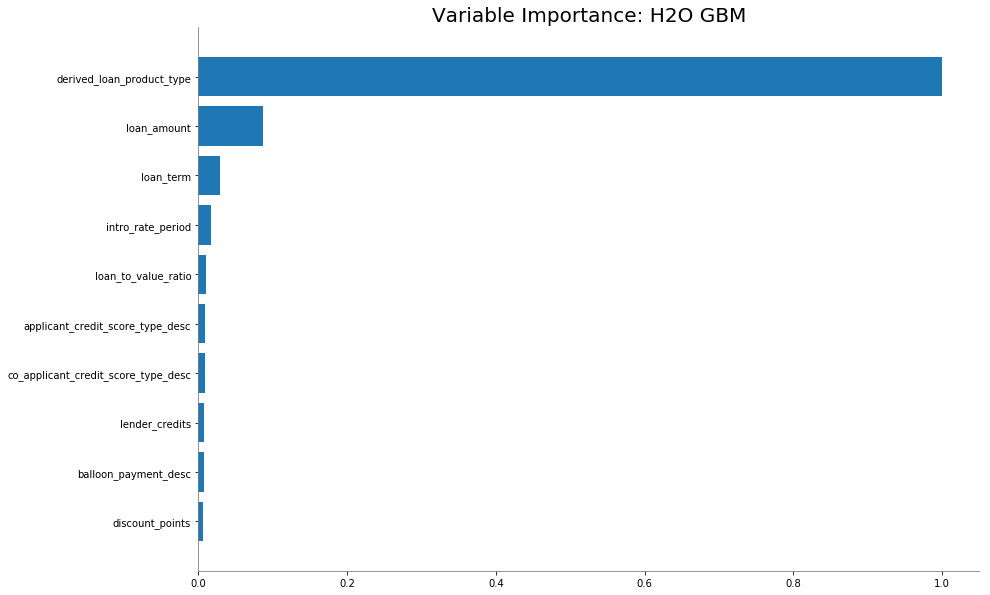

In [20]:
mgbm_default.varimp_plot()

In [21]:
# calculate SHAP values using function predict_contributions
contributions_mgbm_default = mgbm_default.predict_contributions(train)

In [30]:
# convert the H2O Frame to use with shap's visualization functions
contributions_matrix_mgbm_default = contributions_mgbm_default.as_data_frame().as_matrix()
# shap values are calculated for all features
shap_values_mgbm_default = contributions_matrix_mgbm_default[:,0:len(X)-1]
# expected values is the last returned column
expected_value_mgbm_default = contributions_matrix_mgbm_default[:,len(X)-1].min()

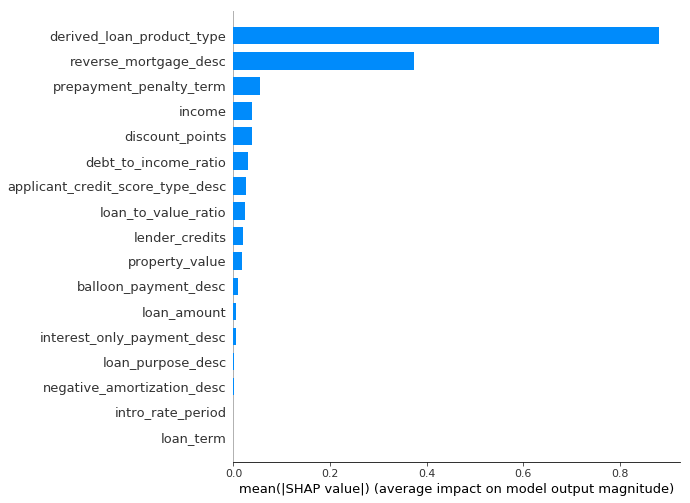

In [33]:
shap.summary_plot(shap_values_mgbm_default, X, plot_type="bar")